# PROYECTO FINAL: 
## Analisis exploratorio de datos sobre el dataset de partidas de ajedrez

![chess](chess.jpg)

**ABSTRACT**

Este proyecto se enfoca en realizar un análisis exploratorio de datos sobre un conjunto de datos de partidas de ajedrez. El objetivo principal es descubrir patrones subyacentes en los movimientos de diferentes jugadas que conduzcan a la victoria, explorando cómo estos patrones se relacionan con diversos factores como el color de las fichas, el tipo de apertura, entre otros. Para lograr este propósito, se emplearán técnicas de visualización y resúmenes estadísticos con el fin de profundizar en la comprensión de los datos y responder a preguntas clave planteadas sobre este conjunto de datos en particular. Además, se evaluarán las posibles aplicaciones de modelos de aprendizaje automático para predecir resultados de partidas de ajedrez basados en las características observadas.

El análisis exploratorio de datos se llevará a cabo de manera exhaustiva, comenzando por la exploración inicial de las características disponibles en el conjunto de datos. Se examinarán variables como el número de movimientos, las jugadas más comunes, las aperturas más utilizadas y las distribuciones de victorias por color de las fichas. Esta fase de exploración permitirá identificar tendencias y relaciones preliminares entre las diferentes variables, proporcionando una base sólida para análisis más detallados.

Además de explorar los datos de manera descriptiva, se realizarán análisis comparativos entre grupos de datos para comprender mejor la influencia de ciertas variables en los resultados de las partidas. Por ejemplo, se podrían comparar las distribuciones de movimientos entre partidas ganadas por blancas y partidas ganadas por negras para identificar diferencias significativas en las estrategias utilizadas por cada color. Asimismo, se analizará cómo varía la efectividad de diferentes aperturas según el color de las fichas, examinando si algunas aperturas tienden a ser más exitosas para un color en particular.

Además del análisis exploratorio, se explorarán posibles modelos de aprendizaje automático que puedan predecir el resultado de una partida de ajedrez dados ciertos parámetros iniciales, como la apertura utilizada y el color de las fichas. Se evaluará la idoneidad de diferentes algoritmos de aprendizaje automático para este propósito y se ajustarán los modelos para optimizar su rendimiento predictivo.

En resumen, este proyecto busca desentrañar los secretos ocultos en los datos de partidas de ajedrez a través de un análisis detallado y exhaustivo, con el objetivo final de desarrollar modelos predictivos que puedan proporcionar información valiosa sobre los resultados de las partidas. Los hallazgos obtenidos podrían tener aplicaciones prácticas en la mejora del juego estratégico de los jugadores de ajedrez y en la creación de sistemas de asistencia para la toma de decisiones durante las partidas.

## PREGUNTAS E HIPOTESIS DE INTERES

>1. Cuál es la distribución del número de turnos en las partidas de ajedrez?
>2. Existe alguna relacion entre victoria y color elegido?
>3. Hay una tendencia en partidas ganadas segun el tipo de apertura?
>4. Que factores en conjunto tienen una mayor influencia en la victoria?

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
# librerias para ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# Librerias para graficos
from sklearn.metrics import confusion_matrix
import plotly.express as px
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Spectral6

In [3]:
# Ingesta de datos
GAMES = pd.read_csv('games.csv')


In [4]:
GAMES.shape

(20058, 16)

In [5]:
# Verifica si la fuente de datos contiene datos nulos
GAMES.isna().sum()

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

**Este gráfico mostrará la distribución del número de turnos en las partidas de ajedrez, lo que puede ayudar a comprender la duración típica de las partidas y si hay alguna tendencia hacia partidas más cortas o más largas.**

In [25]:

# Creamos Histograma del número de turnos
hist, edges = np.histogram(GAMES['turns'], bins=20)

# Crear la figura
p1 = figure(title="Distribución del número de turnos en las partidas de ajedrez", 
            x_axis_label='Número de Turnos', y_axis_label='Frecuencia')
p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color="blue", line_color="white", alpha=0.5)

 # Agregar herramienta de información al pasar el cursor
p1.add_tools(HoverTool(tooltips=[("Frecuencia", "@top")]))

# Mostrar el grafico
show(p1)

**La visualización creada permite explorar la relación entre la victoria en las partidas de ajedrez y el color de las piezas elegido por los jugadores. Al observar el gráfico, se puede analizar la distribución de las victorias entre las piezas blancas y negras. Si existe una relación entre la victoria y el color de las piezas elegido, se esperaría observar una diferencia notable en la altura de las barras correspondientes a "blancas ganan" y "negras ganan". Una barra significativamente más alta indicaría que ese color de piezas tiene más probabilidades de resultar en una victoria.**

In [26]:
# Contar la frecuencia de cada resultado de partida
count = GAMES['winner'].value_counts()

# Crear ColumnDataSource con los datos
source =ColumnDataSource(data={'winner':count.index, 'count':count.values , 'color':Spectral6[:3]})

# Crear la figura
p = figure(x_range= count.index.tolist(), title="Resultado de las partidas", x_axis_label='Color de las piezas', y_axis_label='Frecuencia')

# Graficar las barras verticales
p.vbar(x='winner', top= 'count' , width= 0.7, legend_field= "winner", source= source, color='color')

# Configurar los labels del grafico
p.xaxis.axis_label = "Resultado Partida"
p.yaxis.axis_label = "Frecuencia"

# Configurar la legenda
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

# Agregar herramienta de información al pasar el cursor
hover = HoverTool()
hover.tooltips = [("Resultado", "@winner"), ("Frecuencia", "@count")]
p.add_tools(hover)

# Mostrar el grafico
show(p)

**El grafico presentara las aperturas más utilizadas en las partidas de ajedrez, lo que puede proporcionar información sobre las estrategias preferidas por los jugadores. Además, se pueden segmentar las aperturas por el color de las piezas para analizar las diferencias en las estrategias de apertura entre los jugadores blancos y negros.**

In [27]:
# Contar la frecuencia de cada apertura
opening_counts = GAMES['opening_name'].value_counts().head(10)

# Crear ColumnDataSource con los datos
source = ColumnDataSource(data={'opening_name': opening_counts.index.tolist(),
                                 'count': opening_counts.values.tolist()})

# Crear la figura
p = figure(y_range=opening_counts.index.tolist(),
           title="Aperturas más Populares", y_axis_label="Apertura", x_axis_label="Frecuencia")

# Graficar las barras horizontales
p.hbar(y='opening_name', right='count',width=0.4, height=0.5, source=source, color='blue')

# Agregar herramienta de información al pasar el cursor
hover = HoverTool()
hover.tooltips = [("Apertura", "@opening_name"), ("Frecuencia", "@count")]
p.add_tools(hover)

# Configurar la leyenda
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

# Mostrar el gráfico
show(p)


C:\Users\abril\AppData\Local\Temp\ipykernel_3944\714894767.py:21: UserWarning:


You are attempting to set `plot.legend.orientation` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.


C:\Users\abril\AppData\Local\Temp\ipykernel_3944\714894767.py:22: UserWarning:


You are attempting to set `plot.legend.location` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.




**Este modelo mostrara que factores se relacionan en una victoria.**

In [6]:
df_chess= GAMES

columns_to_drop = ['winner','opening_name','id', 'victory_status','increment_code', 'white_id', 'black_id', 'moves', 'opening_eco', 'opening_ply','rated', 'created_at', 'last_move_at']
df_chess = df_chess.drop(columns=columns_to_drop)

df_chess.tail(10)

,turns,white_rating,black_rating
20048,25,1252,1233
20049,43,1328,1252
20050,9,1243,1142
20051,58,1237,1231
20052,37,1219,1250
20053,24,1691,1220
20054,82,1233,1196
20055,35,1219,1286
20056,109,1360,1227
20057,78,1235,1339


In [7]:
victory_status = GAMES['victory_status']

# Instancia el LabelEncoder
label_encoder = LabelEncoder()

# Ajusta el LabelEncoder a la forma en que termino la partida y transforma los nombres en números
victory_status_encoded = label_encoder.fit_transform(victory_status)

victory_status_encoded = pd.Series(data=victory_status_encoded , name='victory_status_encoded')
victory_status_encoded


0        2
1        3
2        1
3        1
4        1
        ..
20053    3
20054    1
20055    1
20056    3
20057    1
Name: victory_status_encoded, Length: 20058, dtype: int32

In [8]:
winner = GAMES['winner']

# Instancia el LabelEncoder
label_encoder = LabelEncoder()

# Ajusta el LabelEncoder a los resultados de una partida y transforma los nombres en números
encoded_winner = label_encoder.fit_transform(winner)

encoded_winner = pd.Series(data=encoded_winner , name='encoded_winner')
encoded_winner

0        2
1        0
2        2
3        2
4        2
        ..
20053    2
20054    0
20055    2
20056    2
20057    0
Name: encoded_winner, Length: 20058, dtype: int32

In [9]:
df_chess=pd.concat([df_chess,victory_status_encoded],axis=1)
# Cargar los datos y preparar las características (X) y la variable objetivo (y)

X = df_chess # características
y = encoded_winner  # variable objetivo

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Inicializar el modelo de Bosques Aleatorios
rf_model = RandomForestClassifier(random_state=42)

# Entrenar el modelo utilizando los datos de entrenamiento
rf_model.fit(X_train, y_train)

# Realizar predicciones sobre los datos de prueba
y_pred_rf = rf_model.predict(X_test)

# Calcular la precisión del modelo en los datos de prueba
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Precisión del modelo de Bosques Aleatorios en los datos de prueba:", accuracy_rf)


Precisión del modelo de Bosques Aleatorios en los datos de prueba: 0.7076271186440678


In [10]:
# Evaluar el modelo utilizando validación cruzada
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(rf_model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [33]:
# Mostrar los valores de validacion cruzada
scores

array([0.73021807, 0.70903427, 0.70404984, 0.69345794, 0.71401869,
       0.71775701, 0.70261845, 0.71259352, 0.72319202, 0.69451372,
       0.69283489, 0.70965732, 0.68785047, 0.70716511, 0.72834891,
       0.70529595, 0.7138404 , 0.69513716, 0.72693267, 0.71633416,
       0.70965732, 0.7152648 , 0.71401869, 0.70965732, 0.72274143,
       0.71401869, 0.70885287, 0.70137157, 0.70137157, 0.71446384])

In [145]:
# Mostrar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf)
# Creamos una figura para la matriz de confusión con Plotly Express
fig = px.imshow(cm,
                labels=dict(x="Predicted Label", y="True Label"),
                x=['White', 'Black','Draw'],
                y=['White', 'Black','Draw'],
                color_continuous_scale='Blues')

# Ajustamos el tamaño de la figura
fig.update_layout(width=600, height=500)

# Mostramos la figura
fig.show()


In [44]:
# Graficamoos la distribucion del rating de los jugadores con respecto a la victoria
fig = px.scatter(GAMES ,x='white_rating' , y='black_rating',color='winner', title='Distribucion del rating de los jugadores con respecto a la victoria')
fig.show()

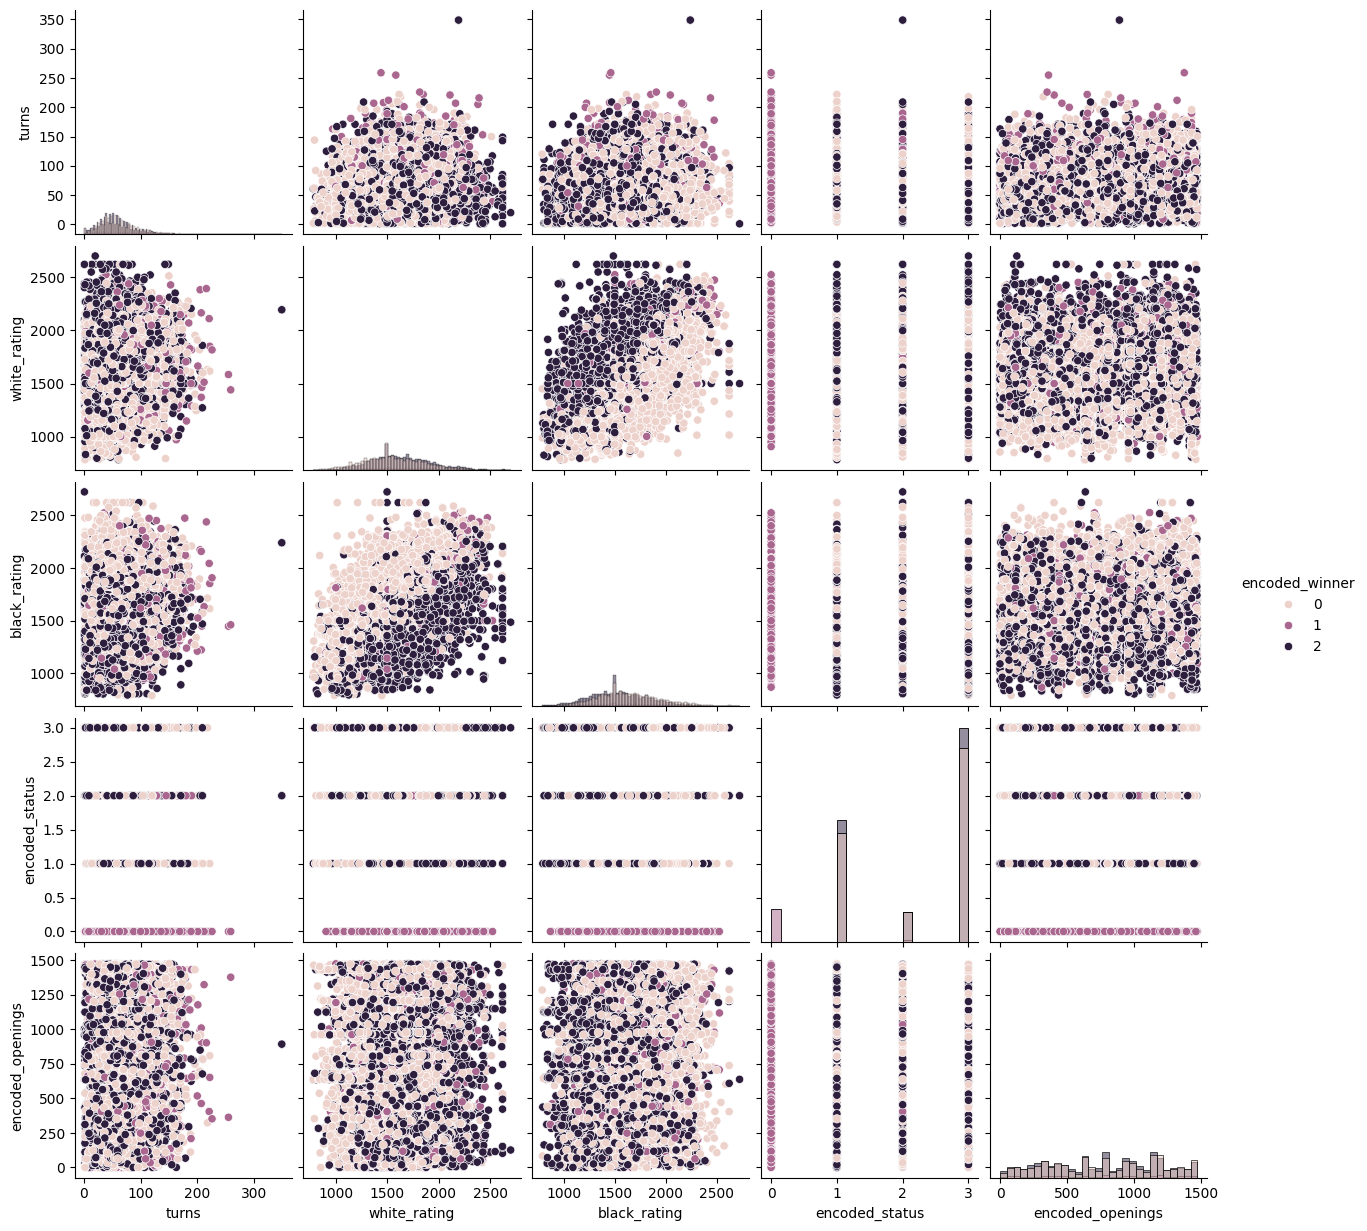

In [152]:
# Concatenar X y y en un solo DataFrame
data = pd.concat([X, y], axis=1)

# Crear pairplot
sns.pairplot(data, hue='encoded_winner', diag_kind='hist')


## CONCLUSIONES

Se puede observar que aunque no existe un factor único determinante para el éxito en el ajedrez, hay ciertos factores que, en conjunto, se acercan al coeficiente de éxito mínimo que debe tener un modelo, en este caso, fue de 0.7, el cual mostró el mejor rendimiento después de varias pruebas. Las características que están relacionadas son los turnos, los rangos de los jugadores blancos y negros, y la forma en que termina la partida. Además, gracias a los gráficos mostrados, se puede apreciar que la relación más fuerte se encuentra en quién resulta ganador cuando hay una mayor diferencia entre el rating de los jugadores, con una tendencia marcada hacia la victoria del jugador con el rating más alto.

El modelo de Random Forest va relacionando estas variables, pero pierde precisión cuando el rating comienza a ser más parejo, ya que en ese caso las partidas tienen resultados más variables o menos predecibles. Sin embargo, también muestra que aquellos encuentros que suelen terminar en empate se encuentran en este último grupo. No se logra obtener una buena puntuación con el modelo de K-means u otras relaciones, ya que no pueden distinguir un grupo por zonas debido a que en la zona donde se ubican los empates se pierden muchos datos que podrían haber resultado en victoria para uno u otro jugador.